In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from decorators import timer, exception_handler, debug

# Optimisation

In [ ]:
class IsingOptimiser:
    def __init__(self, data_path):
        """
        Initialiser for the IsingOptimiser class.

        Args:
        data_path (str): Path to the CSV file containing currency data.
        """
        self.df = pd.read_csv(data_path)
        self.symbols = self.df.columns.tolist()[1:]
        self.data_matrix = self.df.drop(columns=["Date"]).to_numpy()
        self._divide_into_subsets()

    def _divide_into_subsets(self):
        """
        Divide the currencies into approximately equal subsets.
        """
        num_currencies = len(self.symbols)
        subset_size = num_currencies // 4
        extra = num_currencies % 4

        self.subsets_indices = {}
        start = 0
        for i in range(4):
            end = start + subset_size + (1 if i < extra else 0)
            self.subsets_indices[f'subset_{i+1}'] = list(range(start, end))
            start = end

        self.data_subsets = {key: self.data_matrix[:, indices] for key, indices in self.subsets_indices.items()}

        # Print information about how the currencies have been divided into subsets
        for key, indices in self.subsets_indices.items():
            print(f"{key}: Currencies {indices[0]} to {indices[-1]}")

    @staticmethod
    def _log_pseudolikelihood_and_gradients(J, h, X):
        """
        Calculate the log-pseudo-likelihood for the Ising model and its gradients.
        """
        n, d = X.shape  # Number of samples and dimensions
        log_likelihood = 0
        grad_J = np.zeros_like(J)  # Initialise the gradient of J
        grad_h = np.zeros_like(h)  # Initialise the gradient of h

        for i in range(n):
            for j in range(d):
                S_ij = np.dot(J[j, :], X[i, :]) - J[j, j] * X[i, j] + h[j]
                log_likelihood += X[i, j] * S_ij - np.log(2 * np.cosh(S_ij))
                grad_h[j] += X[i, j] - np.tanh(S_ij)
                for k in range(d):
                    if k != j:
                        grad_J[j, k] += X[i, j] * X[i, k] - np.tanh(S_ij) * X[i, k]

        grad_J = (grad_J + grad_J.T) / 2  # Make the J gradient symmetric

        # Return the negative likelihood and gradients for minimisation
        return -log_likelihood, -grad_J, -grad_h

    @timer
    @exception_handler
    def _optimise_subset(self, data_subset, J_subset, h_subset, subset_index):
        """
        Optimise a subset of the Ising model using the L-BFGS-B algorithm.

        Args:
        subset_index (int): Index of the subset being optimised.
        """
        N = J_subset.shape[0]  # Number of spins (currencies)

        # Flatten the J matrix and h vector for the optimisation
        x0 = np.concatenate([J_subset[np.triu_indices(N, k=1)], h_subset])

        def objective_function(x):
            # Construct the symmetric J matrix and calculate the likelihood and gradients
            J, h = self._reconstruct_J_and_h(x, N)
            likelihood, grad_J, grad_h = self._log_pseudolikelihood_and_gradients(J, h, data_subset)
            # Combine and return the likelihood and flattened gradients
            return likelihood, np.concatenate([grad_J[np.triu_indices(N, k=1)], grad_h])
        
        # Execute the optimisation using the objective function and initial guesses
        res = minimize(objective_function, x0, method='L-BFGS-B', jac=True)

        # Reconstruct the optimised J matrix and h vector from the optimisation result
        J_optimised, h_optimised = self._reconstruct_J_and_h(res.x, N)

        # Print the optimisation results for the subset
        print(f"Optimised J matrix for subset {subset_index}: \n{J_optimised}")
        print(f"Optimised h vector for subset {subset_index}: \n{h_optimised}")
        print(f"Optimisation successful for subset {subset_index}: {res.success}")

        return J_optimised, h_optimised, res.success

    @staticmethod
    def _reconstruct_J_and_h(flattened_array, N):
        """
        Helper function to reconstruct the symmetric J matrix and h vector from a flattened array.
        """
        J_upper_tri = flattened_array[:N * (N - 1) // 2]
        h = flattened_array[N * (N - 1) // 2:]

        # Construct the symmetric J matrix from the upper triangular part
        J = np.zeros((N, N))
        J[np.triu_indices(N, k=1)] = J_upper_tri
        J += J.T  # Symmetrise the J matrix
        np.fill_diagonal(J, 0)  # Set the diagonal of the J matrix to 0

        return J, h

    @staticmethod
    def _combine_J_matrices(*matrices):
        """
        Combine smaller J matrices into a larger J matrix.
        """
        size = sum(m.shape[0] for m in matrices)
        J_combined = np.zeros((size, size))

        current_index = 0
        for m in matrices:
            m_size = m.shape[0]
            J_combined[current_index:current_index+m_size, current_index:current_index+m_size] = m
            current_index += m_size

        return J_combined

    @staticmethod
    def _combine_h_vectors(*vectors):
        """
        Combine smaller h vectors into a larger h vector.
        """
        return np.concatenate(vectors)

    @timer
    def optimise_all_subsets(self):
        print("Optimising initial subsets...\n")
        J_initial = {key: np.random.rand(len(indices), len(indices)) for key, indices in self.subsets_indices.items()}
        h_initial = {key: np.random.rand(len(indices)) for key, indices in self.subsets_indices.items()}
        optimised_results = {}
        for index, (key, data_subset) in enumerate(self.data_subsets.items(), 1):
            J_opt, h_opt, success = self._optimise_subset(data_subset, J_initial[key], h_initial[key], index)
            optimised_results[key] = (J_opt, h_opt, success)
            print(f"Subset {key} optimised.\n")

        print("Combining into larger subsets for further optimisation...\n")
        # Combine subsets 1 and 2, and subsets 3 and 4
        J_combined_1_2, h_combined_1_2 = self._combine_J_matrices(optimised_results['subset_1'][0], optimised_results['subset_2'][0]), self._combine_h_vectors(optimised_results['subset_1'][1], optimised_results['subset_2'][1])
        J_combined_3_4, h_combined_3_4 = self._combine_J_matrices(optimised_results['subset_3'][0], optimised_results['subset_4'][0]), self._combine_h_vectors(optimised_results['subset_3'][1], optimised_results['subset_4'][1])

        # Optimise the combined larger subsets
        J_optimised_1_2, h_optimised_1_2, _ = self._optimise_subset(self.data_matrix[:, self.subsets_indices['subset_1'] + self.subsets_indices['subset_2']], J_combined_1_2, h_combined_1_2, '1_2')
        J_optimised_3_4, h_optimised_3_4, _ = self._optimise_subset(self.data_matrix[:, self.subsets_indices['subset_3'] + self.subsets_indices['subset_4']], J_combined_3_4, h_combined_3_4, '3_4')
        print("Larger subsets optimised.\n")

        # Final optimisation with the entire dataset
        print("Performing final optimisation with the entire dataset...\n")
        J_final_combined = self._combine_J_matrices(J_optimised_1_2, J_optimised_3_4)
        h_final_combined = self._combine_h_vectors(h_optimised_1_2, h_optimised_3_4)

        J_optimised_full, h_optimised_full, _ = self._optimise_subset(self.data_matrix, J_final_combined, h_final_combined, 'full')
        print("Final optimisation completed.\n")

        return J_optimised_full, h_optimised_full

    def save_results(self, J_matrix, h_vector, J_file_path, h_file_path):
        """
        Save the optimised J matrix and h vector to CSV files.
        """
        J_df = pd.DataFrame(J_matrix, columns=self.symbols, index=self.symbols)
        h_df = pd.DataFrame({'Symbol': self.symbols, 'h': h_vector})

        J_df.to_csv(J_file_path, index=False)
        h_df.to_csv(h_file_path, index=False, header=False)

        print(f"The optimised J matrix has been saved to '{J_file_path}'.")
        print(f"The optimised h vector has been saved to '{h_file_path}'.")

ising_optimiser = IsingOptimiser('Results/data_matrix.csv')
J_optimised, h_optimised = ising_optimiser.optimise_all_subsets()
ising_optimiser.save_results(J_optimised, h_optimised, J_file_path='Results/J_matrix.csv', h_file_path='Results/h_vector.csv')

subset_1: Currencies 0 to 6
subset_2: Currencies 7 to 13
subset_3: Currencies 14 to 19
subset_4: Currencies 20 to 25
Optimising initial subsets...

Optimised J matrix for subset 1: 
[[ 0.          0.16974151  0.20090152  0.01598079  0.59401933  0.2974987
   0.00735996]
 [ 0.16974151  0.          0.25848471  0.01529574  0.12410511  0.09844882
   0.621001  ]
 [ 0.20090152  0.25848471  0.          0.05273312  0.08685253  0.14679727
   0.14669736]
 [ 0.01598079  0.01529574  0.05273312  0.          0.05469752 -0.09020653
   0.31106847]
 [ 0.59401933  0.12410511  0.08685253  0.05469752  0.          0.19930814
   0.05147054]
 [ 0.2974987   0.09844882  0.14679727 -0.09020653  0.19930814  0.
   0.04725655]
 [ 0.00735996  0.621001    0.14669736  0.31106847  0.05147054  0.04725655
   0.        ]]
Optimised h vector for subset 1: 
[ 0.04731641  0.01319187 -0.01573385 -0.03216079  0.00509062 -0.01556793
 -0.02766881]
Optimisation successful for subset 1: True
Execution time for wrapper: 4.815212011

# Boltzmann Machine

In [15]:
class BoltzmannMachine:
    def __init__(self, data_matrix_df, J_matrix_df, h_vector_df):
        self.data_matrix_df = data_matrix_df
        self.data_matrix = data_matrix_df.drop(columns=["Date"]).to_numpy()
        self.J = J_matrix_df.values
        self.h = h_vector_df[1].values
        self.W = np.zeros(self.data_matrix.shape[1])
        self.b = 0
        self.Z = np.random.choice([-1, 1], size=(self.data_matrix.shape[0],))
        self.symbols = J_matrix_df.columns.tolist()

    @staticmethod
    def _log_pseudo_likelihood_and_gradients(J, h, W, X, Z):
        M, N = X.shape  # M samples (days), N variables (currencies)
        likelihood = 0
        grad_J = np.zeros_like(J)
        grad_h = np.zeros_like(h)
        grad_W = np.zeros_like(W)

        # Loop over all currencies (i) and all days (m)
        for m in range(M):
            for i in range(N):
                # Summation for all other currencies j != i
                sum_j = np.sum(J[i, :] * X[m, :]) - J[i, i] * X[m, i]

                # Calculate the energy contributions without the spin i
                energy_without_i = sum_j + h[i] + W[i] * Z[m]

                # Update the likelihood
                likelihood += X[m, i] * (h[i] + W[i] * Z[m] + sum_j) - np.log(2 * np.cosh(energy_without_i))

                # Calculate the tanh term for gradient updates
                tanh_term = np.tanh(energy_without_i)

                # Update gradients for h, W
                grad_h[i] += X[m, i] - tanh_term
                grad_W[i] += X[m, i] * Z[m] - tanh_term * Z[m]

                # Update gradient for J, ensuring i != j
                for j in range(N):
                    if i != j:
                        grad_J[i, j] += X[m, i] * X[m, j] - tanh_term * X[m, j]

        # Symmetrise the gradient of J outside the loop for efficiency
        grad_J = (grad_J + grad_J.T) / 2
        np.fill_diagonal(grad_J, 0)

        # Return the negative likelihood and gradients for minimisation
        return -likelihood, -grad_J, -grad_h, -grad_W

    @staticmethod
    def _reconstruct_parameters(flattened_array, N):
        """
        Helper function to reconstruct parameters from a flattened array
        """
        # Extract J, h and W from the flattened array
        size_J = N * (N - 1) // 2
        size_h = N
        size_W = N

        J_upper_tri = flattened_array[:size_J]
        h = flattened_array[size_J:size_J + size_h]
        W = flattened_array[size_J + size_h:size_J + size_h + size_W]

        J = np.zeros((N, N))
        J[np.triu_indices(N, k=1)] = J_upper_tri
        J += J.T
        np.fill_diagonal(J, 0)

        return J, h, W

    @staticmethod
    def _predict_Z(data_matrix, W, b):
        """
        Predict Z using the data_matrix and optimised parameters
        """
        Z_predicted = np.zeros(data_matrix.shape[0])
        for i in range(data_matrix.shape[0]):
            # Calculate the effective field for each sample
            h_eff = np.dot(W, data_matrix[i, :]) + b
            # Predict the state of Z based on the sign of the effective field
            Z_predicted[i] = 1 if h_eff > 0 else -1
        return Z_predicted

    @exception_handler
    @timer
    def _optimise_model(self, data, Z):
        """
        Define the optimisation function with the modified likelihood function
        """
        N = data.shape[1]  # Number of variables (currencies)

        def objective_function(x):
            J, h, W = self._reconstruct_parameters(x, N)  # Ensure this matches the structure of x0
            likelihood, grad_J, grad_h, grad_W = self._log_pseudo_likelihood_and_gradients(J, h, W, data, Z)
            
            # Flatten the gradient of J (upper triangle only, since it's symmetric)
            grad_J_flat = grad_J[np.triu_indices(N, k=1)]
            
            # Concatenate all gradients into a one-dimensional array
            grad = np.concatenate([grad_J_flat, grad_h, grad_W])
            return likelihood, grad

        # Flatten the parameters for optimisation
        J_flat = self.J[np.triu_indices(N, k=1)]
        x0 = np.concatenate([J_flat, self.h, self.W])

        # Execute the optimisation
        res = minimize(objective_function, x0, method='L-BFGS-B', jac=True)

        # Reconstruct the optimised parameters
        self.J, self.h, self.W = self._reconstruct_parameters(res.x, N)
        return res.success

    @exception_handler
    @timer
    def train(self, max_iterations=10, convergence_threshold=0.01):
        """
        Optimisation and Prediction Process

        1. 'convergence_threshold' is a parameter representing the fraction of elements in Z that must change for the algorithm to be considered not yet converged.
        2. 'change_threshold' translates this fraction into an actual number of elements.
        3. After each iteration, the method checks how many elements in Z have changed ('num_changed') compared to the previous iteration.
        4. If 'num_changed' is less than or equal to 'change_threshold', the method considers the algorithm to have converged and stops the iterations.
        """
        previous_Z = np.copy(self.Z)
        num_elements = len(self.Z)
        change_threshold = int(convergence_threshold * num_elements)

        for iteration in range(max_iterations):
            print(f"Iteration: {iteration + 1}")

            success = self._optimise_model(self.data_matrix, self.Z)
            if not success:
                print(f"Optimisation did not converge in iteration {iteration}")
                break

            self.Z = self._predict_Z(self.data_matrix, self.W, self.b)

            # Check for convergence
            num_changed = np.sum(self.Z != previous_Z)
            print(f"Number of Z elements changed in iteration {iteration + 1}: {num_changed}")
            
            if num_changed <= change_threshold:
                print(f"Convergence reached in iteration {iteration}")
                break

            previous_Z = np.copy(self.Z)

    def save_results(self, J_matrix_path, h_vector_path, 
                    J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path):
        """
        Save optimised and extended results of the Boltzmann machine.
        """
        # Save optimised results (J matrix and h vector only)
        self._save_optimised_results(J_matrix_path, h_vector_path)

        # Save extended results with Z (Extended J matrix, h vector, and data matrix)
        self._save_extended_results(J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path)

    def _save_optimised_results(self, J_matrix_path, h_vector_path):
        """
        Save the optimised J matrix and h vector.
        """
        pd.DataFrame(self.J, columns=self.symbols, index=self.symbols).to_csv(J_matrix_path, index=False)
        print(f"The optimised J matrix has been saved to '{J_matrix_path}'.")

        h_df = pd.DataFrame({'h': self.h}, index=self.symbols)
        h_df.to_csv(h_vector_path, index=True, header=False)
        print(f"The optimised h vector has been saved to '{h_vector_path}'.")

    def _save_extended_results(self, J_matrix_extended_path, h_vector_extended_path, data_matrix_extended_path):
        """
        Save the extended J matrix, h vector, and data matrix including Z.
        """
        # Extended J matrix
        J_extended = np.zeros((27, 27))
        J_extended[0, 1:] = J_extended[1:, 0] = self.W
        J_extended[1:, 1:] = self.J
        symbols_extended = ['USD'] + self.symbols
        pd.DataFrame(J_extended, columns=symbols_extended, index=symbols_extended).to_csv(J_matrix_extended_path, index=False)
        print(f"The extended optimised J matrix has been saved to '{J_matrix_extended_path}'.")

        # Extended h vector
        h_values_with_b = [self.b] + list(self.h)
        h_df_extended = pd.DataFrame({'h': h_values_with_b}, index=['USD'] + self.symbols)
        h_df_extended.to_csv(h_vector_extended_path, index=True, header=False)
        print(f"The extended optimised h vector has been saved to '{h_vector_extended_path}'.")

        # Extended data matrix with Z
        data_matrix_df_extended = self.data_matrix_df.copy()
        data_matrix_df_extended.insert(1, 'USD', self.Z)
        data_matrix_df_extended.to_csv(data_matrix_extended_path, index=False)
        print(f"Extended data matrix saved to '{data_matrix_extended_path}'.")

In [16]:
# Load data and Initialise Parameters
data_matrix_df = pd.read_csv("Results/data_matrix.csv")
J_matrix_df = pd.read_csv("Results/J_matrix.csv")
h_vector_df = pd.read_csv("Results/h_vector.csv", header=None)

# Create and use BoltzmannMachine
bm = BoltzmannMachine(data_matrix_df, J_matrix_df, h_vector_df)
bm.train(max_iterations=15, convergence_threshold=0.001)

Iteration: 1
Execution time for _optimise_model: 33.288105964660645 seconds
Number of Z elements changed in iteration 1: 2147
Iteration: 2
Execution time for _optimise_model: 114.41868209838867 seconds
Number of Z elements changed in iteration 2: 93
Iteration: 3
Execution time for _optimise_model: 88.19396901130676 seconds
Number of Z elements changed in iteration 3: 79
Iteration: 4
Execution time for _optimise_model: 81.53266620635986 seconds
Number of Z elements changed in iteration 4: 69
Iteration: 5
Execution time for _optimise_model: 86.13787388801575 seconds
Number of Z elements changed in iteration 5: 60
Iteration: 6
Execution time for _optimise_model: 82.91289520263672 seconds
Number of Z elements changed in iteration 6: 68
Iteration: 7
Execution time for _optimise_model: 83.47182202339172 seconds
Number of Z elements changed in iteration 7: 53
Iteration: 8
Execution time for _optimise_model: 76.71601915359497 seconds
Number of Z elements changed in iteration 8: 54
Iteration: 9

In [ ]:
bm.save_results('Results/optimised_J_matrix.csv', 'Results/optimised_h_vector.csv',
                'Results/optimised_J_matrix_extended.csv', 'Results/optimised_h_vector_extended.csv', 'Results/data_matrix_extended.csv')

# Trend Analysis

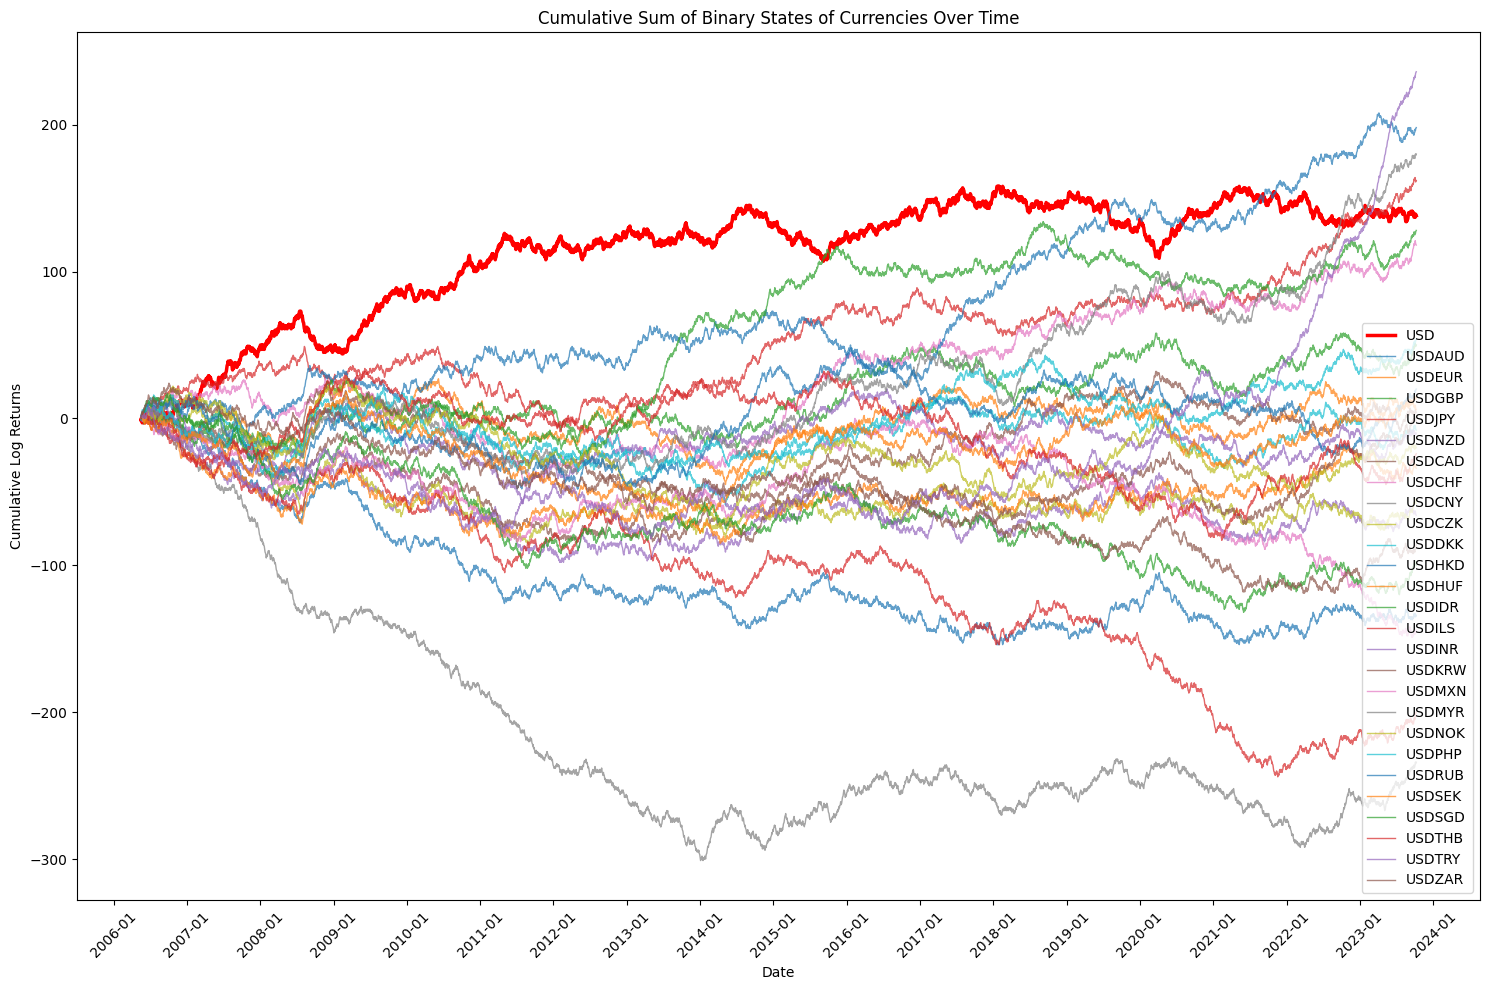

In [18]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define utility functions
def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_binary_states(data, cumsum_data, title, highlight_currency=None):
    """Plots the cumulative sum of binary states for given currencies."""
    plt.figure(figsize=(15, 10))
    for column in cumsum_data.columns:
        if column == highlight_currency:
            # Highlight the specified currency with a different style
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=2.5, color='red')
        else:
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=1, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum of Binary States')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Read and process data
data_matrix_extended = pd.read_csv("Results/data_matrix_extended.csv")

# Convert the 'Date' column to datetime and sort the data
data_matrix_extended['Date'] = pd.to_datetime(data_matrix_extended['Date'])

# Cumulative sum of binary states
data_matrix_cumsum = data_matrix_extended.drop(columns=['Date']).cumsum()

# Plot with USD highlighted
plot_cumulative_binary_states(data_matrix_extended, data_matrix_cumsum, 
                            'Cumulative Sum of Binary States of Currencies Over Time', 
                            highlight_currency='USD')